Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
INFO:tensorflow:Using config: {'_model_dir': '/content/drive/My Drive/Colab Notebooks/savedmodels/final_model_dir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 2, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd5cd9aff28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1

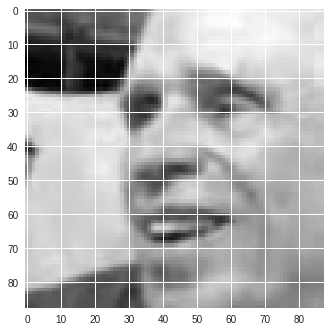

Predicted:  32 , Real:  76

Success example


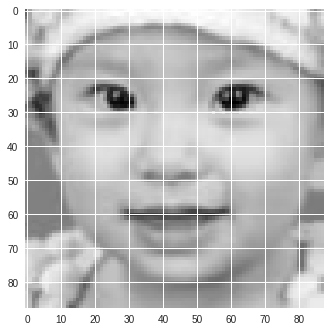

Predicted:  1 , Real:  1


In [0]:
'''
CS 559: Deep Learning
Homework: Age Estimation Using TensorFlow
Muhammed Cavusoglu (21400653) and Kemal Buyukkaya (21200496)
'''

import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# For colab
# '''
from google.colab import drive
drive.mount('/content/drive')
# '''

tf.logging.set_verbosity(tf.logging.INFO)

def cnn_model(features, labels, mode):
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 88, 88, 1])
    
    # Conv1 Layer
    # Compute 32 features using a 4 x 4 filter with ReLU activation
    # Width and height values are preserved (padding)
    # Input Tensor Shape: [batch_size, 88, 88, 1]
    # Output Tensor Shape: [batch_size, 88, 88, 32]
    conv1 = tf.contrib.layers.conv2d(
        inputs = input_layer,
        num_outputs = 32,
        kernel_size = [4, 4],
        padding = 'SAME',
        activation_fn = tf.nn.relu,
        weights_initializer = tf.contrib.layers.xavier_initializer(),
        weights_regularizer = tf.contrib.layers.l2_regularizer(0.8)
    )
    
    # Conv2 Layer
    # Compute 32 features using a 4 x 4 filter with ReLU activation
    # Width and height values are preserved (padding)
    # Input Tensor Shape: [batch_size, 88, 88, 32]
    # Output Tensor Shape: [batch_size, 88, 88, 32]
    conv2 = tf.contrib.layers.conv2d(
        inputs = conv1,
        num_outputs = 32,
        kernel_size = [4, 4],
        padding= 'SAME',
        activation_fn = tf.nn.relu,
        weights_initializer = tf.contrib.layers.xavier_initializer(),
        weights_regularizer = tf.contrib.layers.l2_regularizer(0.8)
    )
    
    # Pooling1 Layer
    # Max Pooling layer with a 2 x 2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 88, 88, 32]
    # Output Tensor Shape: [batch_size, 44, 44, 32]
    pool1 = tf.contrib.layers.max_pool2d(inputs = conv2, kernel_size = [2, 2], stride = 2)
    
    # BatchNorm Layer
    bn1 = tf.contrib.layers.batch_norm(inputs = pool1, activation_fn = None)

    # Conv3 Layer
    # Compute 64 features using a 4 x 4 filter with ReLU activation
    # Width and height values are preserved (padding)
    # Input Tensor Shape: [batch_size, 44, 44, 32]
    # Output Tensor Shape: [batch_size, 44, 44, 64]
    conv3 = tf.contrib.layers.conv2d(
        inputs = bn1,
        num_outputs = 64,
        kernel_size = [4, 4],
        padding= 'SAME',
        activation_fn = tf.nn.relu,
        weights_initializer=tf.contrib.layers.xavier_initializer(),
        weights_regularizer = tf.contrib.layers.l2_regularizer(0.8)
    )
    
    # Pooling 2 Layer
    # Max Pooling layer with a 2 x 2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 44, 44, 64]
    # Output Tensor Shape: [batch_size, 22, 22, 64]
    pool2 = tf.contrib.layers.max_pool2d(inputs = conv3, kernel_size = [2, 2], stride = 2)
    
    # BatchNorm Layer
    bn2 = tf.contrib.layers.batch_norm(inputs = pool2, activation_fn = None)
    
    # Reshape Layer
    # Input Tensor Shape: [batch_size, 22, 22, 64]
    # Output Tensor Shape: [batch_size, 22 * 22 * 64]
    pool2_flat = tf.reshape(bn2, [-1, 22 * 22 * 64])

    # FC Layer with 1024 neurons
    fc1 = tf.contrib.layers.fully_connected(inputs = pool2_flat, num_outputs = 1024, activation_fn = None, 
                                           weights_initializer=tf.contrib.layers.xavier_initializer())
    
    # BatchNorm Layer
    bn3 = tf.contrib.layers.batch_norm(inputs = fc1, activation_fn = tf.nn.relu)
	
    # Dropout Layer (0.8 probability of keeping the element)
    dropout1 = tf.contrib.layers.dropout(inputs = bn3, keep_prob = 0.8, is_training = (mode == tf.estimator.ModeKeys.TRAIN))
	
    # FC Layer with 1024 neurons
    fc2 = tf.contrib.layers.fully_connected(inputs = dropout1, num_outputs = 1024, activation_fn = None, 
                                           weights_initializer=tf.contrib.layers.xavier_initializer())
    
    # BatchNorm Layer
    bn4 = tf.contrib.layers.batch_norm(inputs = fc2, activation_fn = tf.nn.relu)
    
    # Dropout Layer (0.8 probability of keeping the element)
    dropout2 = tf.contrib.layers.dropout(inputs = bn4, keep_prob = 0.8, is_training = (mode == tf.estimator.ModeKeys.TRAIN))
    
    # FC Layer with 1024 neurons
    fc3 = tf.contrib.layers.fully_connected(inputs = dropout2, num_outputs = 1024, activation_fn = None, 
                                           weights_initializer=tf.contrib.layers.xavier_initializer())
    
    # BatchNorm Layer
    bn5 = tf.contrib.layers.batch_norm(inputs = fc3, activation_fn = tf.nn.relu)

    # Dropout Layer (0.8 probability of keeping the element)
    dropout3 = tf.contrib.layers.dropout(inputs = bn5, keep_prob = 0.8, is_training = (mode == tf.estimator.ModeKeys.TRAIN))
    
    # Regression Layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 1]
    regression = tf.contrib.layers.fully_connected(inputs = dropout3, num_outputs = 1, activation_fn = None)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
      # Round the predictions
      return tf.estimator.EstimatorSpec(mode = mode, predictions = tf.math.round(regression))
    
    # Loss function
    # loss = tf.losses.mean_squared_error(labels = labels, predictions = regression)
    loss = tf.losses.absolute_difference(labels = labels, predictions = regression)
    loss_to_log = tf.identity(loss, name="loss_to_log")
    
    # For TensorBoard Visualization
    tf.summary.scalar('loss', loss)
    
    # Adam Optimizer
    if mode == tf.estimator.ModeKeys.TRAIN:
      optimizer = tf.train.AdamOptimizer(learning_rate = 0.001, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-08, use_locking = False, name = 'Adam')
      train_op = optimizer.minimize(
          loss = loss,
          global_step = tf.train.get_global_step())
      return tf.estimator.EstimatorSpec(mode = mode, loss = loss, train_op = train_op)

    eval_metric_ops = {
        "MAE": tf.metrics.mean_absolute_error(labels = labels, predictions = regression)
    }
    MAE_to_log = tf.identity(eval_metric_ops["MAE"], name="MAE_to_log")
    
    # For TensorBoard Visualization
    tf.summary.scalar('MAE', MAE_to_log)
    
    return tf.estimator.EstimatorSpec(mode = mode, loss = loss, eval_metric_ops = eval_metric_ops)

def main():
    # Load the data
    # Use below code to re-generate numpy files from images
    # training_data, training_labels, validation_data, validation_labels, test_data, test_labels = _load_dataset()
    
    # For colab
    #'''
    training_data = np.load("/content/drive/My Drive/Colab Notebooks/training_data.npy")
    training_labels = np.load("/content/drive/My Drive/Colab Notebooks/training_labels.npy")
    validation_data = np.load("/content/drive/My Drive/Colab Notebooks/validation_data.npy")
    validation_labels = np.load("/content/drive/My Drive/Colab Notebooks/validation_labels.npy")
    test_data = np.load("/content/drive/My Drive/Colab Notebooks/test_data.npy")
    test_labels = np.load("/content/drive/My Drive/Colab Notebooks/test_labels.npy")
    #'''
    
    # For local 
    '''
    training_data = np.load("training_data.npy")
    training_labels = np.load("training_labels.npy")
    validation_data = np.load("validation_data.npy")
    validation_labels = np.load("validation_labels.npy")
    test_data = np.load("test_data.npy")
    test_labels = np.load("test_labels.npy")
    '''
    
    config = tf.estimator.RunConfig( model_dir='/content/drive/My Drive/Colab Notebooks/savedmodels/final_model_dir',
                                     keep_checkpoint_max=2,
                                     save_checkpoints_steps=1000,
                                     save_checkpoints_secs=None)
    
    # Estimator
    age_estimator = tf.estimator.Estimator(model_fn = cnn_model, config = config)
    
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = {"x": training_data},
        y = training_labels,
        batch_size = 32,
        num_epochs = None,
        shuffle = True
    )
    
    eval_logging_hook = tf.train.LoggingTensorHook(tensors={"MAE_to_log": "MAE_to_log"}, every_n_iter = 1)
    
    '''
    # Training and evaluation (early stopping based on validation MAE)
    for i in range(100000):
      age_estimator.train(
          input_fn = train_input_fn,
          steps = 100
          #,hooks = [logging_hook]
      )

      # Evaluate the model and print results
      eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": validation_data}, y = validation_labels, num_epochs = 1, shuffle = False)

      eval_results = age_estimator.evaluate(input_fn = eval_input_fn, hooks = [eval_logging_hook], steps = 1)
      print(eval_results)
    
      mae = eval_results["MAE"]
      
      # Early stopping based on validation MAE
      if mae < 5.75:
        break
    '''    
    
    # Test (comment out the block above when testing)
    test_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": test_data}, y = test_labels, num_epochs = 1, shuffle = False)
    
    # For report only
    #test_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": validation_data}, y = validation_labels, num_epochs = 1, shuffle = False)
    #test_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": training_data}, y = training_labels, num_epochs = 1, shuffle = False)
    
    test_results = age_estimator.evaluate(input_fn = test_input_fn, hooks = [eval_logging_hook], steps = 1)
    print(test_results)
    
    # Informative success/failure examples
    sample_predictions = age_estimator.predict(input_fn = test_input_fn)
    pred_list = np.array(list(sample_predictions))
    pred_list2 = pred_list
    failure_index = np.argmax(np.absolute(np.subtract(pred_list, test_labels)))
    success_index = np.argmin(np.absolute(np.subtract(pred_list2, test_labels)))
    
    print("Failure example")
    failure = plt.imshow(test_data[failure_index], cmap="gray")
    plt.show()
    print("Predicted: ", int(pred_list[failure_index]), ", Real: ", int(test_labels[failure_index]))
    
    print("\nSuccess example")
    success = plt.imshow(test_data[success_index], cmap="gray")
    plt.show()
    print("Predicted: ", int(pred_list[success_index]), ", Real: ", int(test_labels[success_index]))
    
def _load_dataset():
    # Training set
    training_data = []
    training_labels = []
    
    tr_path = 'UTKFace_downsampled/training_set'
    for filename in os.listdir(tr_path):
        training_labels.append(int(filename[:3]))
        img_data = cv2.imread(os.path.join(tr_path, filename), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        img_data = cv2.resize(img_data, (88, 88)) # Resize
        training_data.append(img_data)
        
    training_data = np.array(training_data, dtype='float32')
    training_labels = np.array(training_labels, dtype='float32')
    training_labels = training_labels.reshape(len(training_labels), 1)
    np.save('training_data', training_data)
    np.save('training_labels', training_labels)
    
    # Validation set
    validation_data = []
    validation_labels = []
    
    v_path = 'UTKFace_downsampled/validation_set'
    for filename in os.listdir(v_path):
        validation_labels.append(int(filename[:3]))
        img_data = cv2.imread(os.path.join(v_path, filename), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        img_data = cv2.resize(img_data, (88, 88)) # Resize
        validation_data.append(img_data)
        
    validation_data = np.array(validation_data, dtype='float32')
    validation_labels = np.array(validation_labels, dtype='float32')
    validation_labels = validation_labels.reshape(len(validation_labels), 1)
    np.save('validation_data', validation_data)
    np.save('validation_labels', validation_labels)
    
    # Test set
    test_data = []
    test_labels = []
    
    t_path = 'UTKFace_downsampled/test_set'
    for filename in os.listdir(t_path):
        test_labels.append(int(filename[:3]))
        img_data = cv2.imread(os.path.join(t_path, filename), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        img_data = cv2.resize(img_data, (88, 88)) # Resize
        test_data.append(img_data)
        
    test_data = np.array(test_data, dtype='float32')
    test_labels = np.array(test_labels, dtype='float32')
    test_labels = test_labels.reshape(len(test_labels), 1)
    np.save('test_data', test_data)
    np.save('test_labels', test_labels)
    
    return training_data, training_labels, validation_data, validation_labels, test_data, test_labels
    
if __name__ == "__main__":
  main()

In [0]:
# For downloading the model as a zip file
import shutil as sh
sh.make_archive("/content/drive/My Drive/Colab Notebooks/final_model_dir", 'zip', '/content/drive/My Drive/Colab Notebooks/savedmodels/final_model_dir')